# Download and preprocess is given in VoxNet_classification.ipynb

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import zipfile
import os

with zipfile.ZipFile('ModelNet10_voxelized.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## Load datasets

In [18]:
from ModelNet10VoxelDataset import ModelNet10VoxelDataset
import torch
import numpy as np
#train_data1 = ModelNet10VoxelDataset("./ModelNet10_voxelized","train",32, 'partial', p = 0.5)
train_data1 = ModelNet10VoxelDataset("./ModelNet10_voxelized","train",32, 'sliced_x', p = 0.5)
train_data2 = ModelNet10VoxelDataset("./ModelNet10_voxelized","train",32, 'sliced_y', p = 0.5)
train_data3 = ModelNet10VoxelDataset("./ModelNet10_voxelized","train",32, 'sliced_z', p = 0.5)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data2, train_data3])

train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=20, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)


#test_data1 = ModelNet10VoxelDataset("./ModelNet10_voxelized","test",32, 'partial', p = 0.5)
test_data1 = ModelNet10VoxelDataset("./ModelNet10_voxelized","test",32, 'sliced_x', p = 0.5)
test_data2 = ModelNet10VoxelDataset("./ModelNet10_voxelized","test",32, 'sliced_y', p = 0.5)
test_data3 = ModelNet10VoxelDataset("./ModelNet10_voxelized","test",32, 'sliced_z', p = 0.5)
test_data = torch.utils.data.ConcatDataset([test_data1, test_data2, test_data3])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True) # shuffle only to get both partial and sliced when plotting

print(f'Number of training samples: {len(train_data)}.\nNumber of validation samples: {len(val_data)} \nNumber of test samples: {len(test_data)}.')

Number of training samples: 10775.
Number of validation samples: 1198 
Number of test samples: 2724.


## Visualize some data

In [10]:
import matplotlib.pyplot as plt
# Function inspired from: https://github.com/AutoDeep/VoxNet/blob/master/src/utils/visualization.py

import matplotlib.pyplot as plt
import numpy as np

def plot3DVoxel(voxels_list, titles, res):
    # Check if the number of titles matches the number of voxel grids
    assert len(voxels_list) == len(titles), "Number of titles must match number of voxel grids"
    
    # Create a figure with subplots based on the number of voxel grids
    num_voxels = len(voxels_list)
    fig = plt.figure(figsize=(15, 5))  # Adjust size to fit all subplots

    for i, voxels in enumerate(voxels_list):
        ax = fig.add_subplot(1, num_voxels, i + 1, projection='3d')
        
        occupied = (voxels == 1)
        free = (voxels == 0)

        colors = np.zeros(voxels.shape + (4,))  # (4,) indicates RGBA
        colors[free] = [0.1, 0.1, 0.1, 0.1]
        colors[occupied] = [0.8, 0.8, 0.8, 1.0]

        ax.set_xlabel('X', fontsize=9)
        ax.set_ylabel('Y', fontsize=9)
        ax.set_zlabel('Z', fontsize=9)
        ax.set_xlim(0, res)
        ax.set_ylim(0, res)
        ax.set_zlim(0, res)

        ax.voxels(voxels, facecolors=colors, edgecolor='k', linewidth=0.8)
        ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()


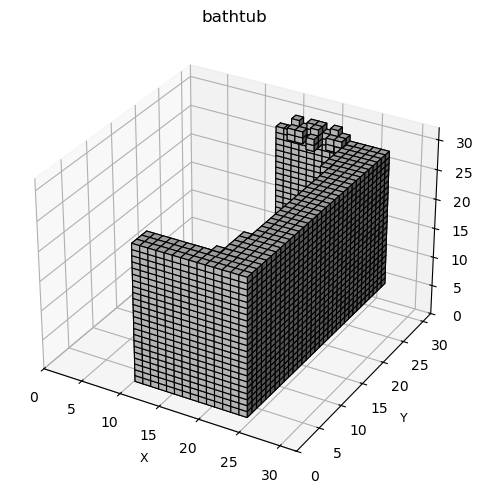

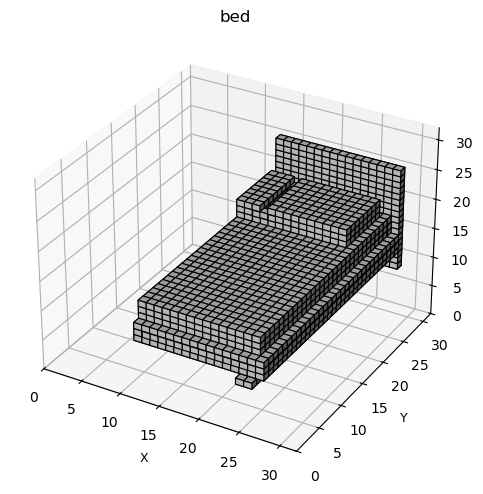

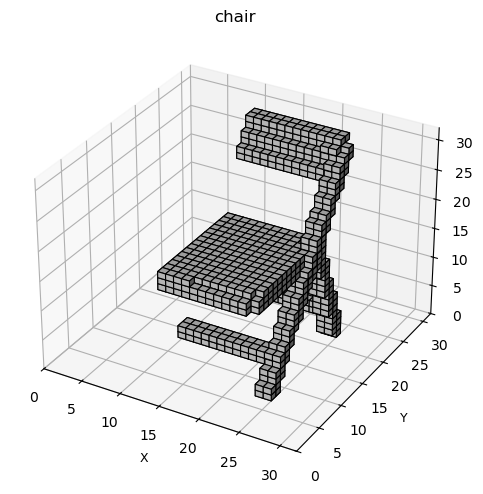

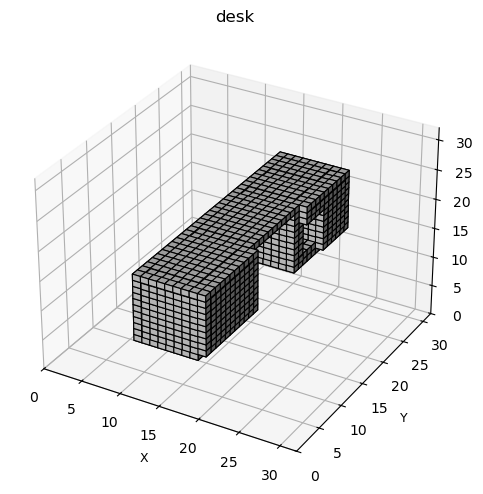

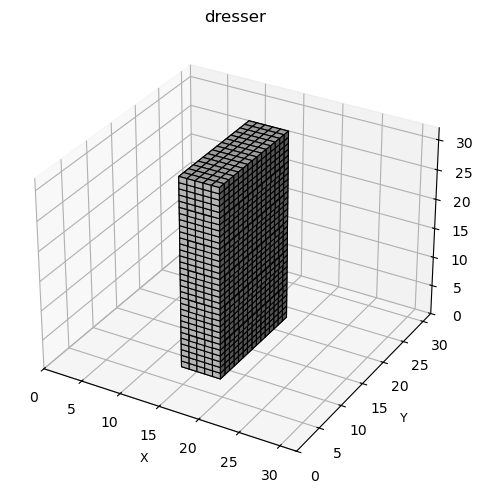

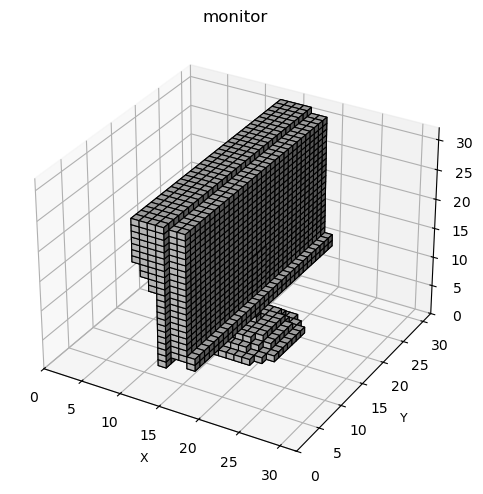

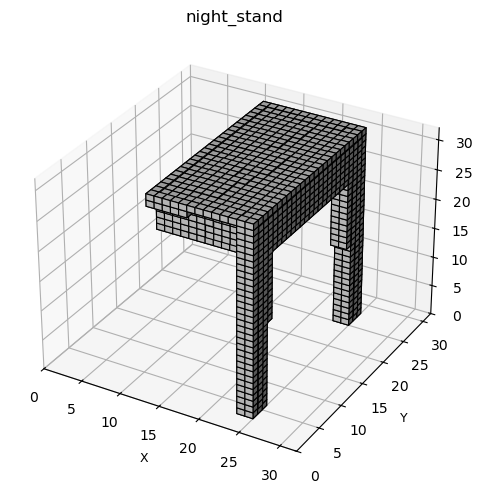

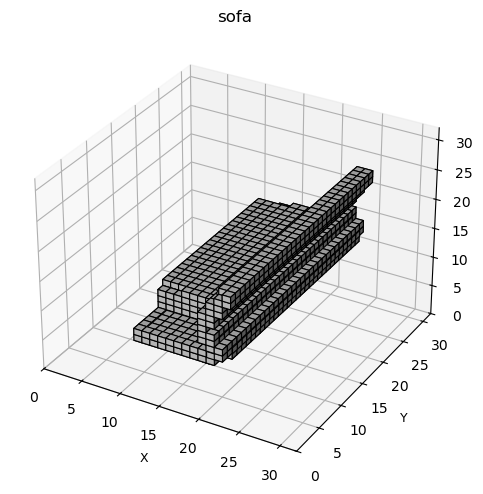

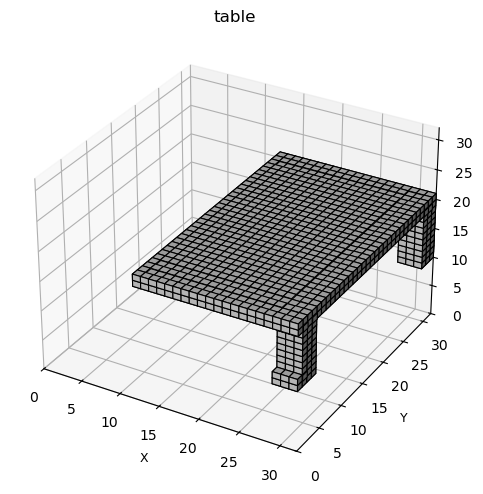

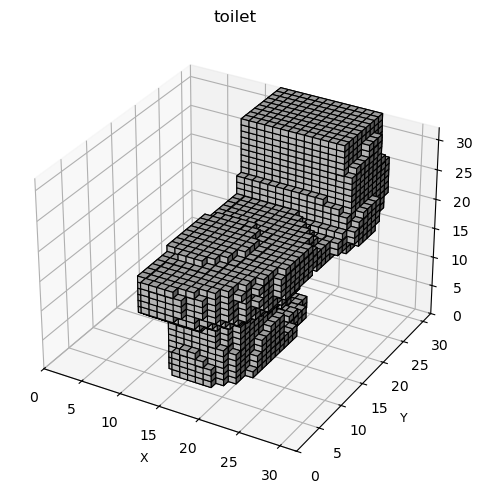

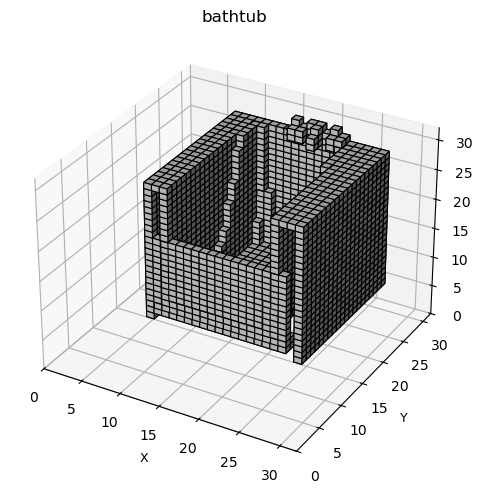

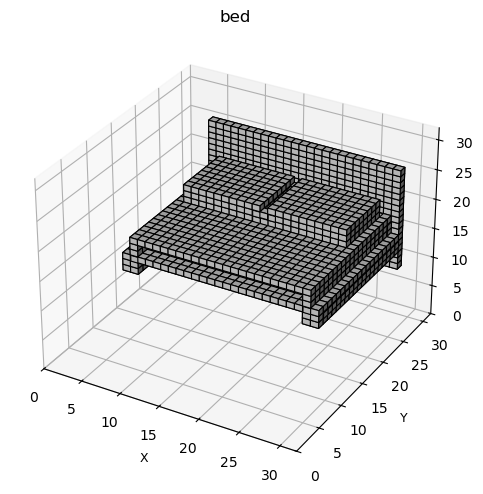

KeyboardInterrupt: 

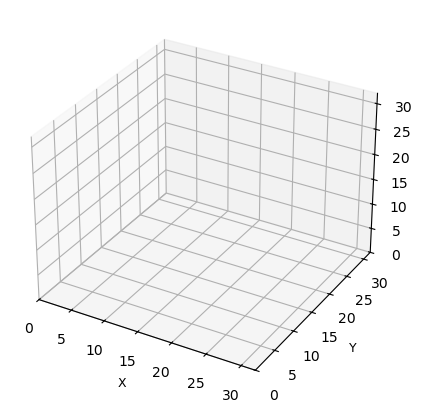

In [207]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Load dataset
original_data1 = ModelNet10VoxelDataset("./ModelNet10_voxelized", "train", 32, 'sliced_x', p=0.4)
original_data2 = ModelNet10VoxelDataset("./ModelNet10_voxelized", "train", 32, 'sliced_y', p=0.4)
original_data3 = ModelNet10VoxelDataset("./ModelNet10_voxelized", "train", 32, 'sliced_z', p=0.4)

original_datas = [original_data1,original_data2,original_data3]
for original_data in original_datas:
    # Track whether we've visualized a sample for each class
    visualized = defaultdict(bool)

    for i in range(len(original_data)):
        sample = original_data.samples[i]
        file_path, class_idx = sample
        class_name = original_data.idx_to_class[class_idx]
        if visualized[class_name]:
            continue

        voxel_input, voxel_target = original_data[i]

        title = f"{class_name}"
        plot3DVoxel([voxel_input.squeeze(0)], [title], res=32)

        # Mark this class as visualized
        visualized[class_name] = True


## Define model and setup for training

In [227]:
import importlib
import VoxNetAE  # regular import
import torch
importlib.reload(VoxNetAE)  # force reload to pick up changes
from VoxNetAE import VoxNetAE
voxnet_ae = VoxNetAE(latent_dim=512)
print(voxnet_ae)

path = 'voxnet_ae_512_latent.pth'

VoxNetAE(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=6912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6912, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (1): ReLU()
    (2): ConvTranspose3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(2, 2, 2), output_padding=(1, 1, 1))
  )
)


In [7]:
from torch.optim.lr_scheduler import LambdaLR
from torch import nn

# optimizer = torch.optim.SGD(voxnet_ae.parameters(), lr=0.001,momentum=0.9 ,weight_decay=0.001) # parameters from the paper
# scheduler = LambdaLR(optimizer, lr_lambda=lambda batch_idx: 0.1 ** (batch_idx // 40000)) ## each 40000 decrease the lr by a factor of 10

optimizer = torch.optim.Adam(voxnet_ae.parameters(), lr = 0.00025)
loss_fn = nn.BCEWithLogitsLoss()


## Train model

In [229]:
def train_one_epoch(epoch_index):
    total_loss = 0.0

    for batch_idx, (voxels, labels) in enumerate(train_loader):
        logits = voxnet_ae(voxels)

        optimizer.zero_grad()
        loss_cls = loss_fn(logits, labels)
        loss_cls.backward()
        optimizer.step()
        #scheduler.step()

        loss_value = loss_cls.item()
        total_loss += loss_value

    return total_loss / len(train_loader)


In [230]:
def validation_one_epoch(epoch_index):
    with torch.no_grad():
        total_loss = 0.0

        for batch_idx, (voxels, labels) in enumerate(val_loader):
            logits = voxnet_ae(voxels)
            loss_cls = loss_fn(logits, labels)

            loss_value = loss_cls.item()
            total_loss += loss_value

        return total_loss / len(val_loader)

In [231]:
import matplotlib.pyplot as plt
def plot_training_validation_loss(train_loss,val_loss):
    plt.plot(np.arange(0,len(train_loss)), train_loss, label='Training loss per batch' )
    plt.plot(np.arange(0,len(val_loss)), val_loss, label='Validation loss per batch')

    plt.vlines(np.argmin(val_loss),ymin=0, ymax=max(max(train_loss),max(val_loss)), linestyle=':',colors='k', label='Minimum validation loss') 

    plt.xlabel('Epochs')
    plt.ylabel('Loss per batch')
    plt.title('Training vs validation loss')
    plt.grid()
    plt.legend()
    plt.show()


In [232]:
epochs = 30
val_loss_data = np.zeros(epochs)
train_loss_data = np.zeros(epochs)

best_val_loss = float('inf')
best_model = None

for epoch in range(0,epochs):
    avg_loss_train = train_one_epoch(epoch)
    avg_loss_val = validation_one_epoch(epoch)

    train_loss_data[epoch] = avg_loss_train
    val_loss_data[epoch] = avg_loss_val

    print(f'>> Epoch {epoch+1} complete. Training loss per epoch: {avg_loss_train:.4f}. Validation loss per epoch: {avg_loss_val:.4f}')

    # Save best model. 
    if (avg_loss_val < best_val_loss):
        best_val_loss = avg_loss_val
        best_model = voxnet_ae.state_dict()

>> Epoch 1 complete. Training loss per epoch: 0.3006. Validation loss per epoch: 0.2404
>> Epoch 2 complete. Training loss per epoch: 0.2217. Validation loss per epoch: 0.2102
>> Epoch 3 complete. Training loss per epoch: 0.1991. Validation loss per epoch: 0.1939
>> Epoch 4 complete. Training loss per epoch: 0.1862. Validation loss per epoch: 0.1835
>> Epoch 5 complete. Training loss per epoch: 0.1759. Validation loss per epoch: 0.1749
>> Epoch 6 complete. Training loss per epoch: 0.1671. Validation loss per epoch: 0.1672
>> Epoch 7 complete. Training loss per epoch: 0.1595. Validation loss per epoch: 0.1608
>> Epoch 8 complete. Training loss per epoch: 0.1530. Validation loss per epoch: 0.1554
>> Epoch 9 complete. Training loss per epoch: 0.1468. Validation loss per epoch: 0.1498
>> Epoch 10 complete. Training loss per epoch: 0.1415. Validation loss per epoch: 0.1457
>> Epoch 11 complete. Training loss per epoch: 0.1366. Validation loss per epoch: 0.1415
>> Epoch 12 complete. Training

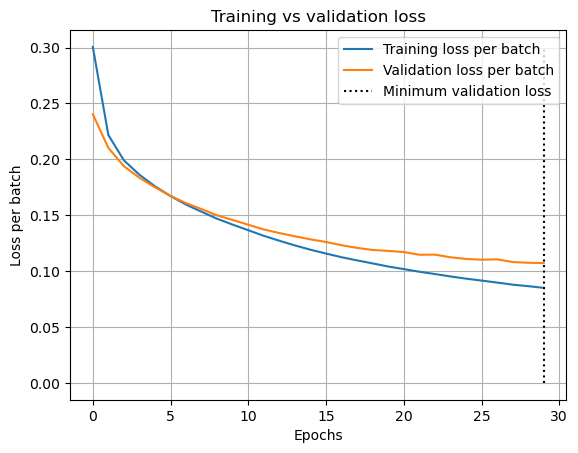

In [233]:
plot_training_validation_loss(train_loss_data, val_loss_data)

In [234]:

torch.save(best_model, path)

In [5]:
import importlib
import VoxNetAE  # regular import
import torch
importlib.reload(VoxNetAE)  # force reload to pick up changes
from VoxNetAE import VoxNetAE
voxnet_ae = VoxNetAE(latent_dim=512)
print(voxnet_ae)
path = 'voxnet_ae_512_latent.pth'
voxnet_ae.load_state_dict(torch.load(path))

VoxNetAE(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=6912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6912, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (1): ReLU()
    (2): ConvTranspose3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (3): ReLU()
    (4): ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(2, 2, 2), output_padding=(1, 1, 1))
  )
)


C:\Users\eric_\AppData\Local\Temp\ipykernel_32856\1372629031.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  voxnet_ae.load_state_dict(torch.load(path))


<All keys matched successfully>

In [16]:
voxnet_ae.eval()
running_cls_loss = 0.0

total_intersection = 0.0
total_union = 0.0

with torch.no_grad():
    for batch_idx, (in_voxels, gt_voxels) in enumerate(test_loader):
        pred_voxels = voxnet_ae(in_voxels)

        loss_cls = loss_fn(pred_voxels, gt_voxels)
        running_cls_loss += loss_cls.item()

        probs = torch.sigmoid(pred_voxels)
        # print(probs)
        preds = (probs >= 0.3).float()

        # IoU Calculation, dont sum over batch axis
        intersection = np.logical_and(gt_voxels, preds).sum(axis=(1, 2, 3))
        union = np.logical_or(gt_voxels, preds).sum(axis=(1, 2, 3)) 

        total_intersection += intersection.sum().item()  # Summing over all batches
        total_union += union.sum().item() 

    avg_loss_cls = running_cls_loss / len(test_loader)
    iou = 100 * total_intersection / total_union if total_union > 0 else 0.0

    print(f'Classification Loss: {avg_loss_cls:.4f}, IoU: {iou:.2f}%')


Classification Loss: 0.1298, IoU: 56.23%


torch.Size([1, 32, 32, 32])


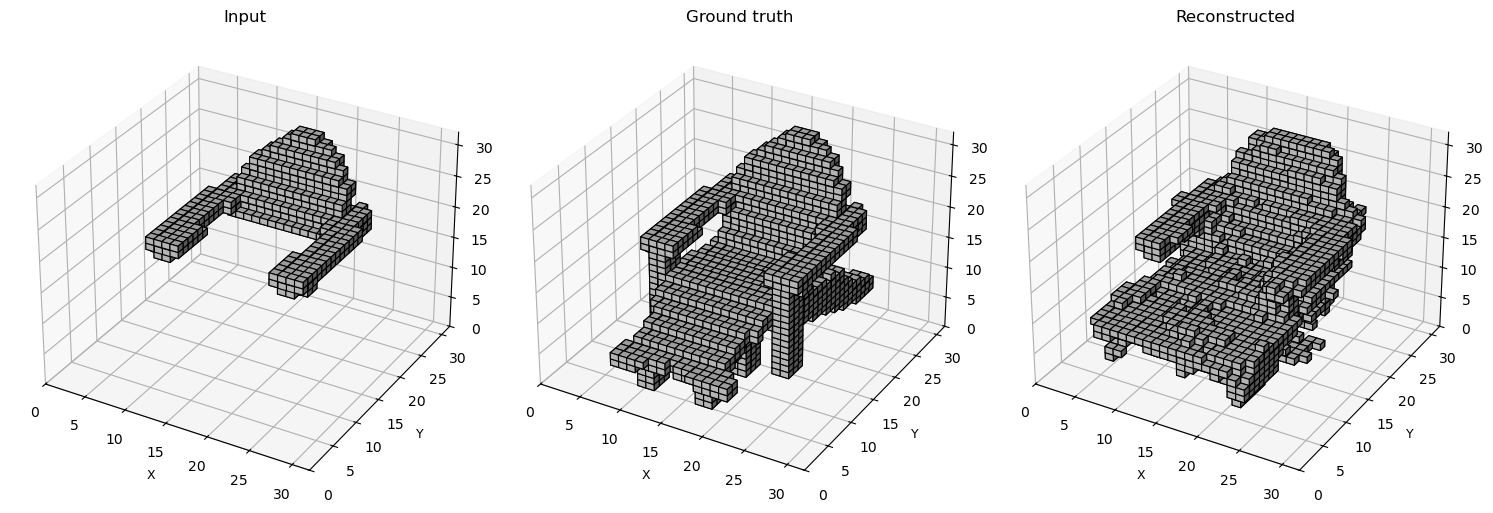

torch.Size([1, 32, 32, 32])


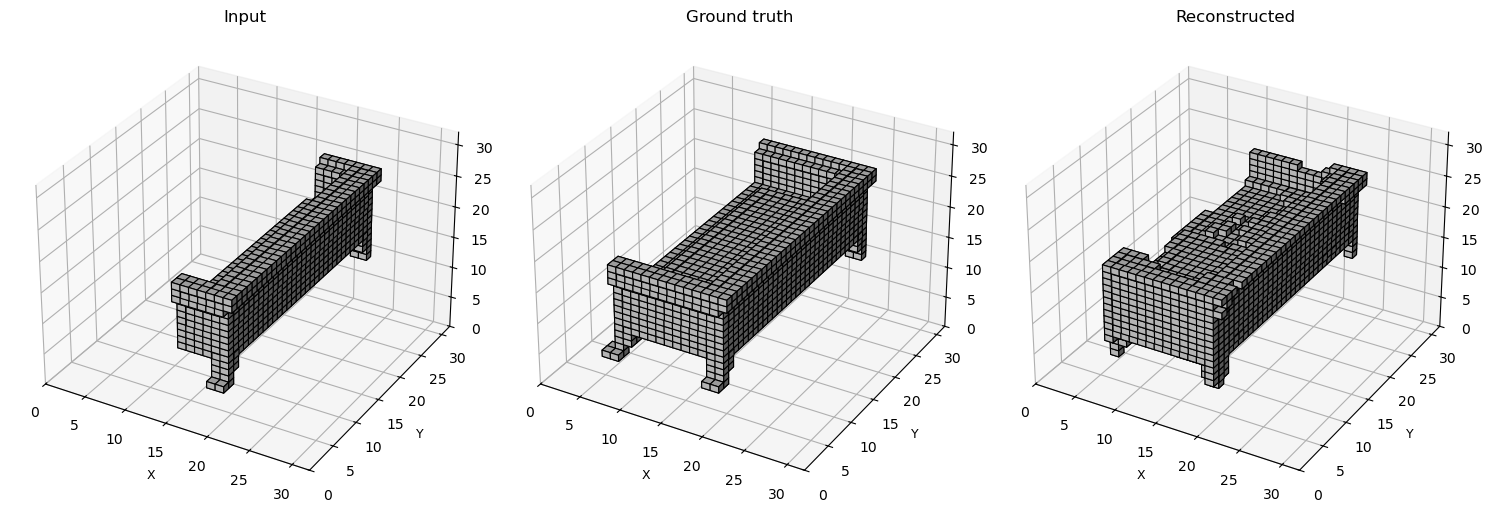

torch.Size([1, 32, 32, 32])


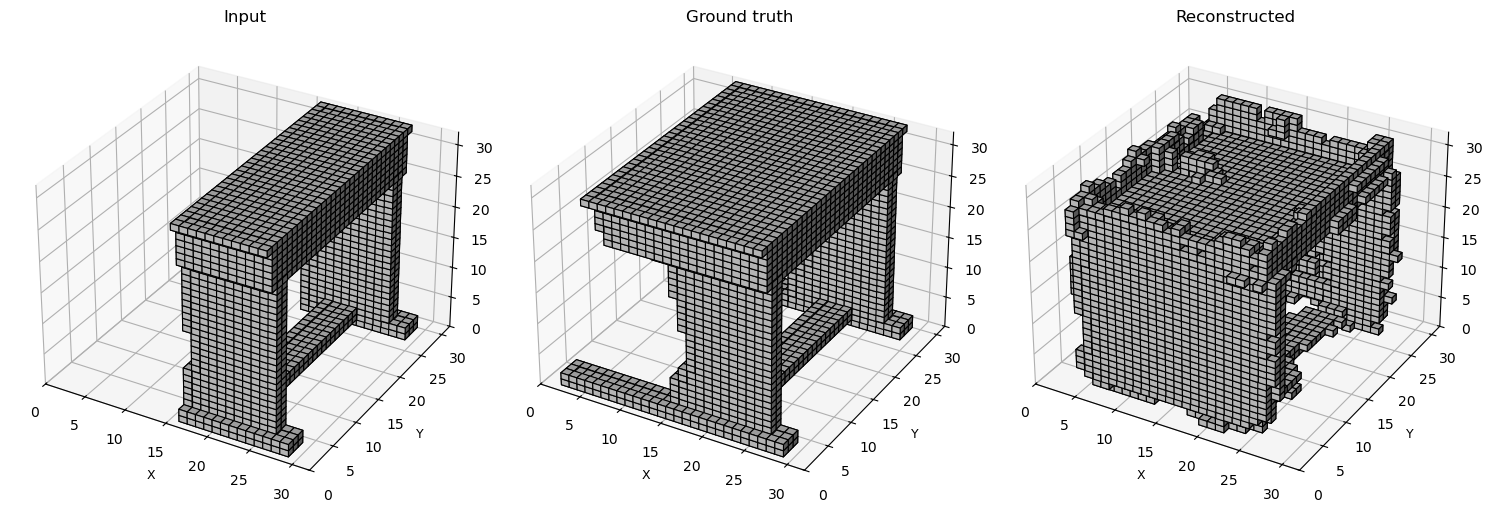

torch.Size([1, 32, 32, 32])


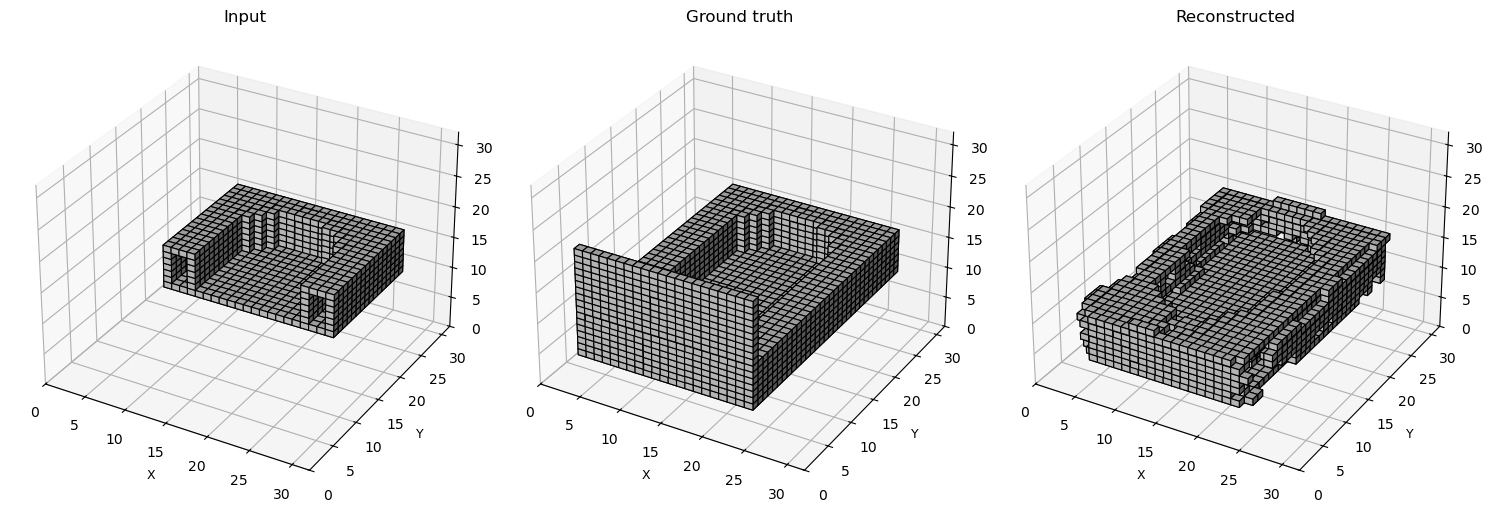

torch.Size([1, 32, 32, 32])


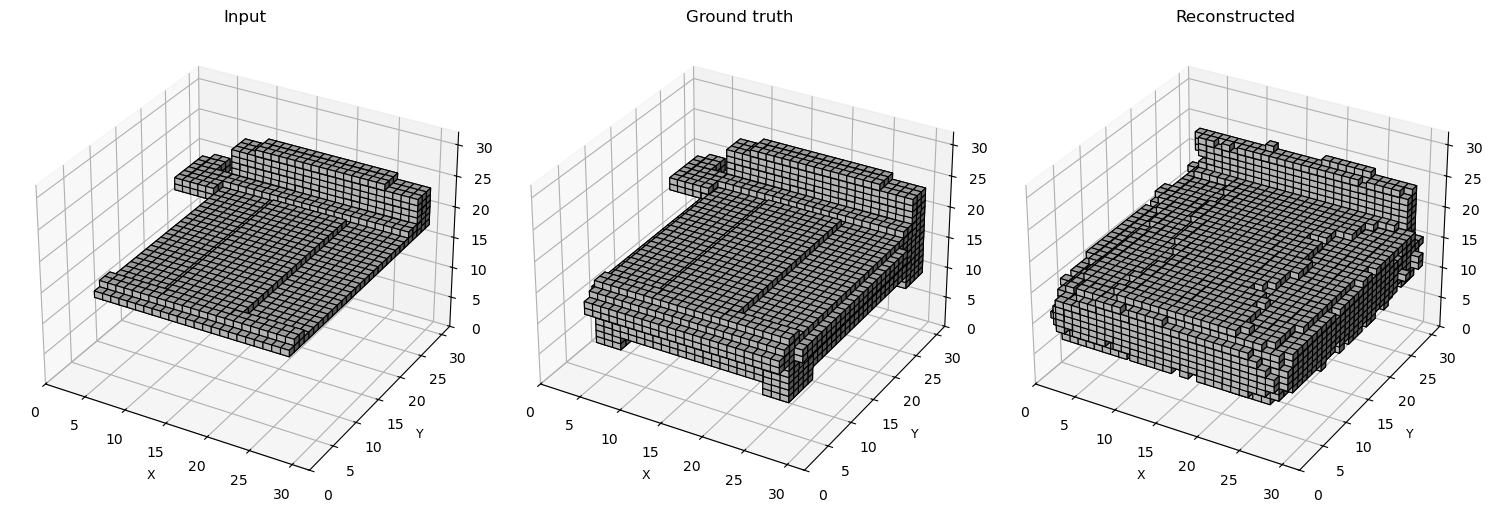

torch.Size([1, 32, 32, 32])


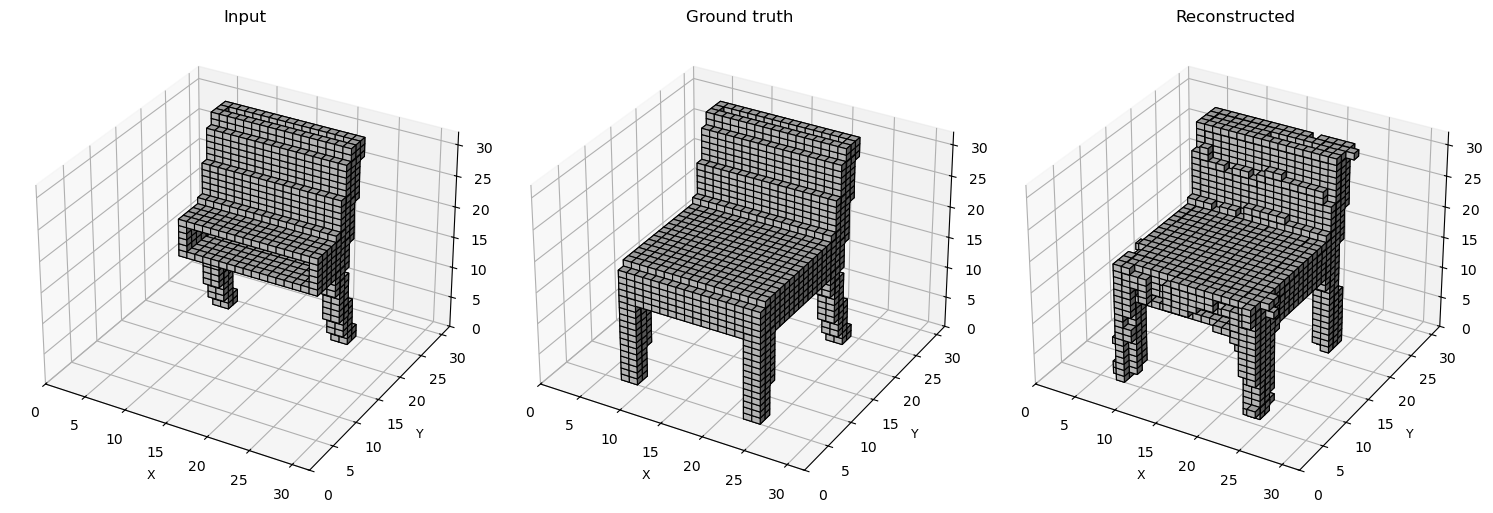

torch.Size([1, 32, 32, 32])


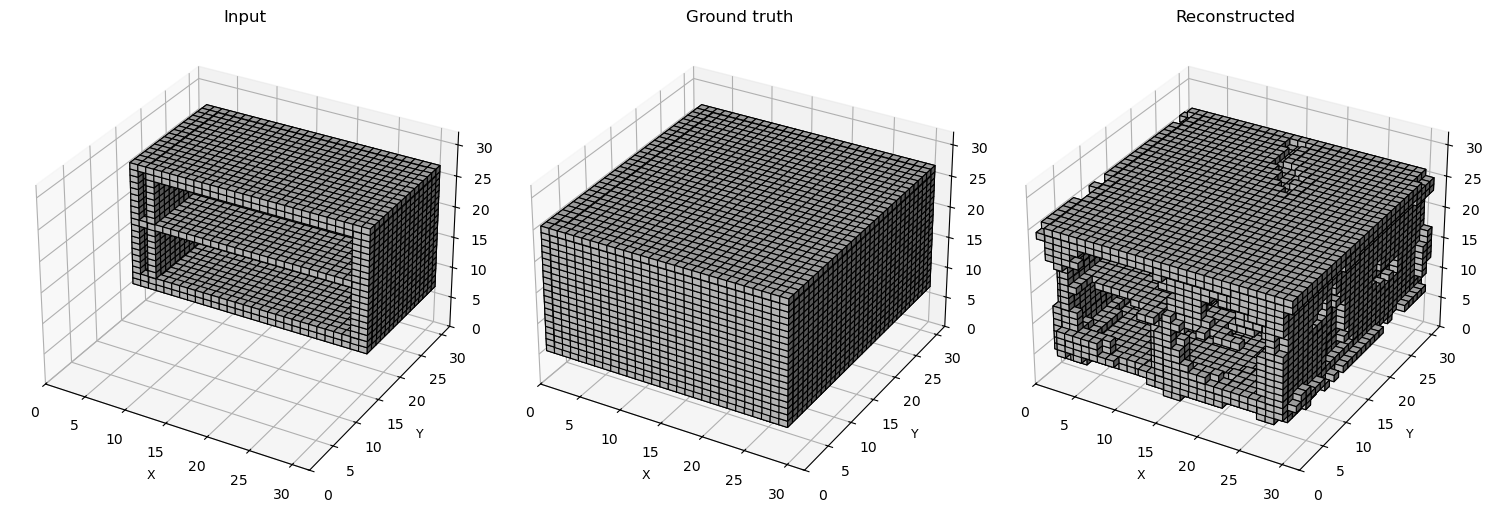

torch.Size([1, 32, 32, 32])


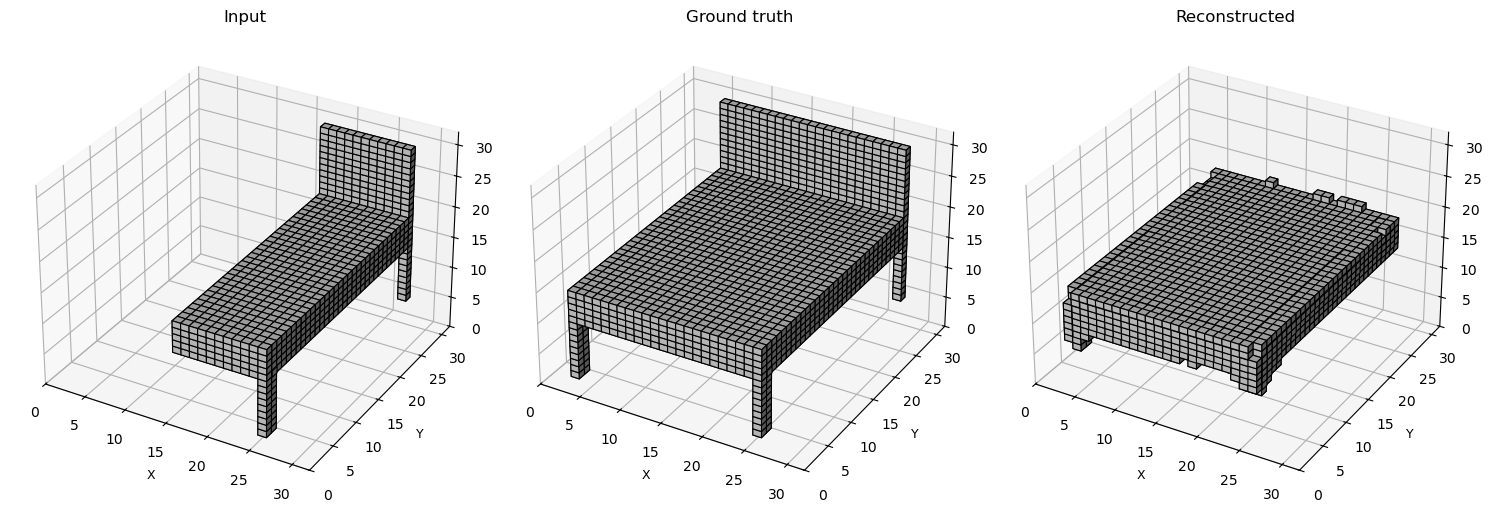

torch.Size([1, 32, 32, 32])


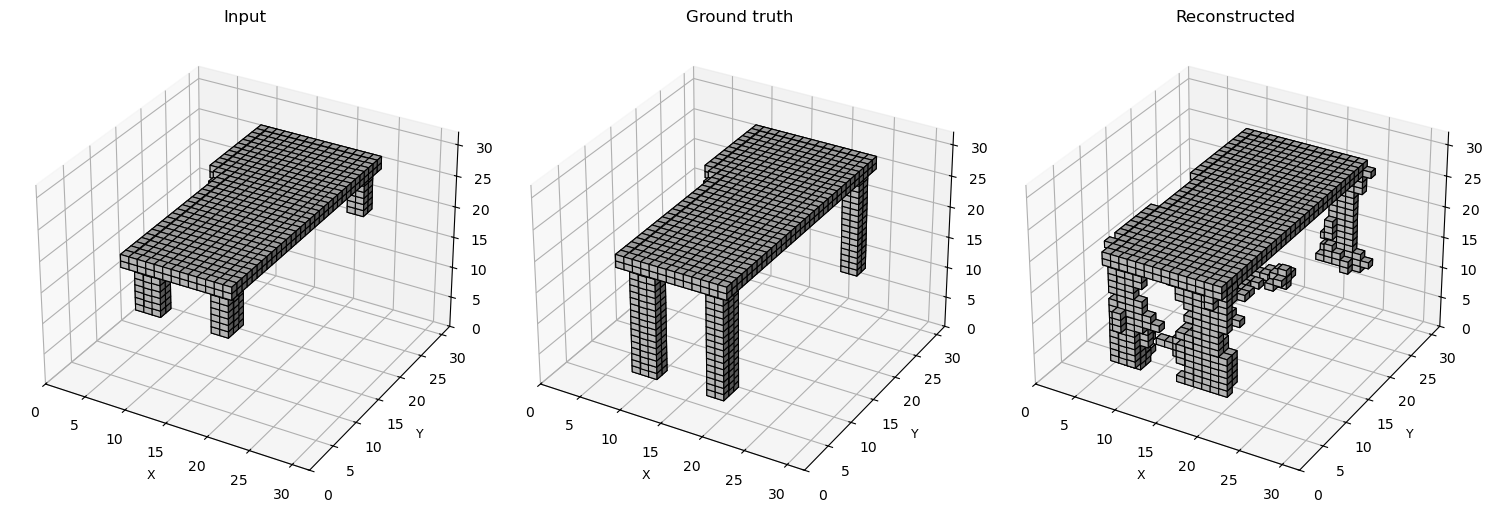

In [21]:
n_plotted = 0
with torch.no_grad():
    for batch_idx, (in_voxels, gt_voxels) in enumerate(test_loader):

        if n_plotted == 9: break

        pred_voxels = voxnet_ae(in_voxels)  # output logits
        # Sigmoid + threshold to get binary predictions
        probs = torch.sigmoid(pred_voxels)
        preds = (probs >= 0.3).float()
        print(preds[0].shape)
        titles = ['Input','Ground truth', 'Reconstructed']
        voxel_grids_to_plot = [in_voxels[0].squeeze(0),gt_voxels[0].squeeze(0),preds[0].squeeze(0)]
        plot3DVoxel(voxel_grids_to_plot,titles,32)
        n_plotted +=1


In [20]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_params(voxnet_ae)

print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 7156929


## Comments

BCELoss seem to work better. Try this with the naive voxnet AE

latent dim from 128 to 256 significant improvement, try 512 and 1024 as well